# ⭐Jonas Questions
- 
- 
- 


# ⭐Imports


In [1]:
from processing_functions import *
%matplotlib inline

TensorFlow Version:  2.1.0


---

# ⭐Step 1: Preprocessing

🔴 Define helper function that
- drops the constituents column 
- converts NaN to 0
- converts values to floats

In [2]:
# preprocess(event)

# ⭐Step 2: Create Image & Average Image

### 🔵 Create Image

🔴 Define Helper Function that takes an event as input and returns an image
- Bins coordinates (η, φ, pT)
- Creates image using np.histogram2d()

In [3]:
#create_image(event, R=1.5, pixels=60)

### 🔵 Create Average Image

🔴 Define Helper Function that reads events directly from a file and returns an average image


**NOTE:** event_no list implementation for multiple images is not working properly

In [4]:
#average_image(pixels=60, R=1.5, event_no=12178, display=False):

Example (Image Progression)

In [5]:
#average_image(pixels = 100, event_no=[25, 300, 3000, 12000], display=True)

# ⭐Step 3: Extract Maxima

🔴 Define 3 Helper Functions that 

Return one vector each with the highest pT and its η, φ. (For the three maximum pT's)

- **1st function**: 1st maximum pT and its η, φ
- **2nd function**: 2nd maximum pT and its η, φ
- **3rd function**: 3rd maximum pT and its η, φ

In [6]:
#find_max1(event)
#find_max2(event)
#find_max3(event)

---

# ⭐Step 4: Centre Image

For each row, we centre a new coordinate system so that the highest pT constituent's coordinates are (φ', η') = (0, 0). <br />
This corresponds to rotating and boosting along the beam direction to center the jet.

**φ Tranformation**<br />
For the φ transformation, we subtract the φ (of the max pT) from all φ's in that row. <br />
If the values exceed [-π, π], we add 2π to the final result (if it's <-π) or subtract 2π from the final result (if it's >π). This makes sure that no values exceed the original φ interval. <br />
This has the effect of making the φ (corresponding to the max pT for that row) equal to 0 in each row, and shifting the other φ's by that same angle, while maintaining a range of 2π. <br />

**η Transformation**<br />
How does η transform? We need a Lorentz Transformation. 

**Paper** (E) <br />
Histograms binned in
either the angular separation of events or the rapidity separation of events can
be contributed to by events whose centre of mass frames are boosted by arbitrary velocities with respect to the rest frame of the detector, the lab frame.
The resulting histograms are undistorted by these centre of mass frame boosts
parallel to the beam axis, as the dependent variable is invariant with respect
to this sub–class of Lorentz boosts.

**Paper** (F): make code cell below markdown to display


In [7]:
#<img src="h1.png" width="500"> <img src="h2.png" width="500">

🔴 Define Helper Function <br />
Centers image around (φ', η') = (0, 0). Both transformations are linear (so far). 


In [8]:
#center(event, max123, output='event', R=1.5, pixels=60):

# ⭐Step 5: Rotate Image

Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.

**Paper (C)** <br />
"Rotation: Rotation is performed to remove the stochastic nature of the decay
angle relative to the η − φ coordinate system."

🔴 Define Helper Function that

- 
- 
- 

In [9]:
#rotate(event, max2)

# ⭐Step 6: Flip Image

Flip all the constituents such that the constituents with the 3rd highest pT is on the right-half plane, i.e. at (φ’,η’)=(f,e) with f > 0

🔴 Define Helper Function that

- 
- 
- 

In [10]:
#flip(event, max3)

---

# ⭐ Building Classifier

### 🔴 Import Data

1. Import signal/background data (~7min)
2. Concatenate & Shuffle signal/background data
3. Convert to tf.data.Dataset object


**Save Dataset** **NOTE: PICKLE IMPLEMENTATION DOES NOT WORK YET**

The easiest way is to pickle it using to_pickle:

`df.to_pickle(file_name)`, where to save it, usually as a .pkl

Then you can load it back using:

`df = pd.read_pickle(file_name)`


### 🔴 Load s&b data (~24mins)

In [11]:
# Load Previously saved data
data_s = np.array(pd.read_csv('data_s_csv').iloc[:, 1:])
data_b = np.array(pd.read_csv('data_b_csv').iloc[:, 1:])

log

In [12]:
# # Load Previously saved data
# data_s = np.array(pd.read_csv('data_s_log_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b__log_csv').iloc[:, 1:])

normal

In [13]:
# # Load Previously saved data
# data_s = np.array(pd.read_csv('data_s_normal_csv').iloc[:, 1:])
# data_b = np.array(pd.read_csv('data_b_normal_csv').iloc[:, 1:])

In [14]:
# # Import, Preprocess, Create Dat|aset
# start = time.time()
# data_s = create_dataset_CNN('dataset_signal.dat')
# data_b = create_dataset_CNN('dataset_background.dat')
# end = time.time()
# print('Time taken: {:.2f} mins'.format((end-start)/60))

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_log_csv')
# pd.DataFrame(data_b).to_csv('data_b_log_csv')

In [15]:
# Create s&b labels
slabels = np.ones(data_s.shape[0]//40)
blabels = np.zeros(data_b.shape[0]//40)

In [16]:
# Concatenate examples and labels
data = np.concatenate((data_s, data_b), axis=0)
labels = np.concatenate((slabels, blabels), axis=0)

num_of_examples = data.shape[0] // 40     # divide by 40 because 1st dim is 40 * num_of_examples
num_of_labels = labels.shape[0]
print('Total Events:', num_of_examples)
print('Total Labels:', num_of_labels)

Total Events: 29449
Total Labels: 29449


In [17]:
# Reshape examples (for CNN)
examples = data.reshape(num_of_examples, 40, 40, 1)
examples.shape

(29449, 40, 40, 1)

### 🔴 Train-Val-Test Split

In [18]:
from sklearn.model_selection import train_test_split

train_examples, test_examples, train_labels, test_labels = train_test_split(examples, labels, test_size=0.15, random_state=42)

train_examples, val_examples, train_labels, val_labels = train_test_split(train_examples, train_labels, test_size=0.18, random_state=42)

print('Train: ', train_examples.shape, train_labels.shape)
print('Val: ', val_examples.shape, val_labels.shape)
print('Test: ', test_examples.shape, test_labels.shape)

Train:  (20525, 40, 40, 1) (20525,)
Val:  (4506, 40, 40, 1) (4506,)
Test:  (4418, 40, 40, 1) (4418,)


### 🔴 Convert to tf.data.Dataset

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_examples, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

print(train_data)
print(val_data)
print(test_data)

<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>


#### 🔴 (Old) train-val-test split

In [58]:
# train_size = int(0.7 * num_of_examples)
# val_size = int(0.15 * num_of_examples)
# test_size = int(0.15 * num_of_examples)

# print(train_size, val_size, test_size)

# train_data = data.take(train_size)
# test_data = data.skip(train_size)
# val_data = test_data.skip(val_size)
# test_data = test_data.take(test_size)

# print(train_data)
# print(val_data)
# print(test_data)

In [59]:
# from sklearn.utils import shuffle

# # Convert .dat files into DataFrame objects
# data_s = pd.DataFrame([i.strip().split() for i in open("tth_semihad.dat").readlines()])
# data_b = pd.DataFrame([i.strip().split() for i in open("wjets.dat").readlines()])

# # Label data
# data_s['label'] = np.ones(data_s.shape[0])
# data_b['label'] = np.zeros(data_b.shape[0])

# # Concatenate & Shuffle
# data = pd.concat([data_s, data_b])
# data = shuffle(data)

# # Extract labels & drop
# labels = np.array(data['label'])
# data = data.drop('label', axis=1)

#### 🔴 Create Batches

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Theory guide: https://www.tensorflow.org/guide/data_performance#prefetching

In [20]:
batch_size = 64

def normalise(image, label):
    image = tf.cast(image, tf.int64)                 # Set dtype to int64
    label = tf.cast(label, tf.int64)
    #image /= np.amax(image.numpy())                    # Normalise Image
    #image = tf.image.resize(image, (pixels, pixels, 1))   # Resize image to 40x40
    return image, label



train_batches = train_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

val_batches = val_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)  # or prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 

test_batches = test_data.cache().shuffle(num_of_examples).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

train_batches

<PrefetchDataset shapes: ((64, 40, 40, 1), (64,)), types: (tf.int64, tf.int64)>

In [21]:
num_of_batches_train = len(train_labels) // batch_size
num_of_batches_val = len(val_labels) // batch_size
num_of_batches_test = len(test_labels) // batch_size

print(num_of_batches_train, num_of_batches_val, num_of_batches_test)

320 70 69


#### 🔴 Visualise Data  
(TRY REMOVING NORMALISATION FROM PREPROCESSING (create_dataset), THEN DISPLAY IMAGE, THEN WHEN CREATING BATCHES USE .MAP(NORMALISE) TO NORMALISE IMAGES)

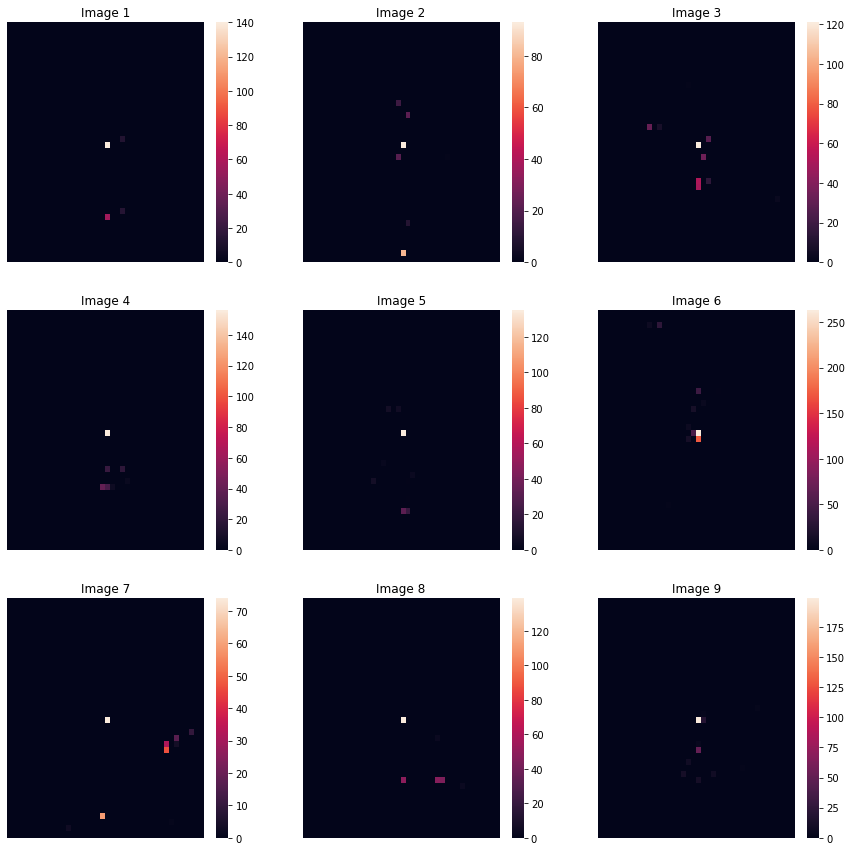

In [22]:
plt.figure(figsize=(15,15))

for images, labels in train_batches.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        sns.heatmap(images[i].numpy().reshape(40, 40))
        #plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Image {}'.format(i+1))
        plt.axis("off")

### 🔴 Build the Model

Look up ConvNet TF Tutorial and make a Conv2D model

### 🔴 Compile the Model
- **Optimizer** -- Determines how the model is updated based on the data it sees and its loss function
- **Loss Function** -- Measures how accurate the model is during training
- **Metrics** -- Monitors the training and testing steps. 

### 🔴 Learning Curve

In [26]:
input_shape=(40, 40, 1)
kernel_size = 2
padding='valid'
activation = 'tanh'

prop = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
loss_list = []
accuracy_list = []

for i in prop:
    model = tf.keras.Sequential([
                  tf.keras.Input(shape=input_shape),
                  tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
                  tf.keras.layers.MaxPooling2D(),
                  tf.keras.layers.Flatten(),
                  tf.keras.layers.Dense(128, activation=activation),
                  tf.keras.layers.Dense(2, activation = 'softmax')
        ])


    # Compile Model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


    print('\n\n', i, '\n')

    # Fit model to training data
    EPOCHS = 4

    history = model.fit(train_batches.take(int(i*num_of_batches_train)), 
              epochs=EPOCHS,
              validation_data=val_batches.take(int(i*num_of_batches_val)), 
              verbose=0
              )
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)
    print('\nLoss on the Test Set: {:,.3f}'.format(loss))
    print('Accuracy on the Test Set: {:.1%}'.format(accuracy))



 0.1 


Loss on the Test Set: 0.676
Accuracy on the Test Set: 59.4%


 0.2 


Loss on the Test Set: 0.680
Accuracy on the Test Set: 59.4%


 0.4 


Loss on the Test Set: 0.675
Accuracy on the Test Set: 59.3%


 0.6 


Loss on the Test Set: 0.675
Accuracy on the Test Set: 59.3%


 0.8 


Loss on the Test Set: 0.676
Accuracy on the Test Set: 59.4%


 1 


Loss on the Test Set: 0.677
Accuracy on the Test Set: 59.3%


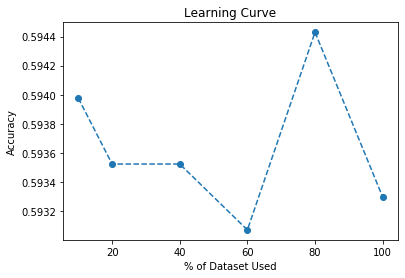

In [27]:
plt.plot(np.array(prop)*100, accuracy_list, linestyle='--', marker='o')
plt.xlabel('% of Dataset Used')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.show()

### 🔴 Fit the Model

**Early Stopping**: <br /> 
Stop training when there is no improvement in the validation loss for 5 consecutive epochs or when metric gain is less than 0.001

**Save Best**: <br />
Saves the best model

## Notes
#### Activation Function (non normalised)
- **Relu**: sometimes results in all predictions being 0 
- **tanh**: solves this issue; accuracy (n = 1): 73
- **softsign**: solves and performs similarly to tanh
- **elu**: solves and performs slightly better than tanh

#### Activation Function (log)
- **softsign**: only softsign works. accuracy: 67

#### Activation Function (normal)
- Nothing has worked

### Other hyperparameters
- kernel_size = 2, 3, 5, 7 perform best (very similarly to one another)
- padding = 'valid', 'same' result in very similar performance
- filters: tried small (8 in all) to large (256 in all) and they perform similarly to one another. 

In [23]:
input_shape=(40, 40, 1)
kernel_size = 2
padding='valid'
activation = 'tanh'

activations = ['elu', 'exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
kernels = [1, 3, 5, 7, 9, 11]
paddings = ['valid', 'same']
filters = [8, 16, 64, 256, 512]

for i in range(1):

    model = tf.keras.Sequential([
              tf.keras.Input(shape=input_shape),
              tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(2, activation = 'softmax')
    ])

    #model.summary()

    # Compile Model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)
    save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

    print('\n\n', activation, '\n')

    # Fit model to training data
    EPOCHS = 15

    history = model.fit(train_batches, 
              epochs=EPOCHS,
              callbacks= [early_stopping, save_best],
              validation_data=val_batches, 
              verbose=1
              )
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)

    print('\nLoss on the Test Set: {:,.3f}'.format(loss))
    print('Accuracy on the Test Set: {:.1%}'.format(accuracy))



 tanh 

Train for 320 steps, validate for 70 steps
Epoch 1/15
320/320 [==============================] - 12s 36ms/step - loss: 0.5982 - accuracy: 0.6888 - val_loss: 0.6343 - val_accuracy: 0.6525
Epoch 2/15
320/320 [==============================] - 11s 35ms/step - loss: 0.5802 - accuracy: 0.7113 - val_loss: 0.5854 - val_accuracy: 0.7071
Epoch 3/15
320/320 [==============================] - 11s 36ms/step - loss: 0.5747 - accuracy: 0.7183 - val_loss: 0.6025 - val_accuracy: 0.6888
Epoch 4/15
320/320 [==============================] - 11s 35ms/step - loss: 0.5699 - accuracy: 0.7239 - val_loss: 0.6014 - val_accuracy: 0.6920
Epoch 5/15
320/320 [==============================] - 11s 35ms/step - loss: 0.5679 - accuracy: 0.7247 - val_loss: 0.6263 - val_accuracy: 0.6656
Epoch 6/15
320/320 [==============================] - 11s 35ms/step - loss: 0.5643 - accuracy: 0.7297 - val_loss: 0.5957 - val_accuracy: 0.6964
Epoch 7/15
320/320 [==============================] - 11s 35ms/step - loss: 0.5624 

### 🔴 Model-Complexity Graph 

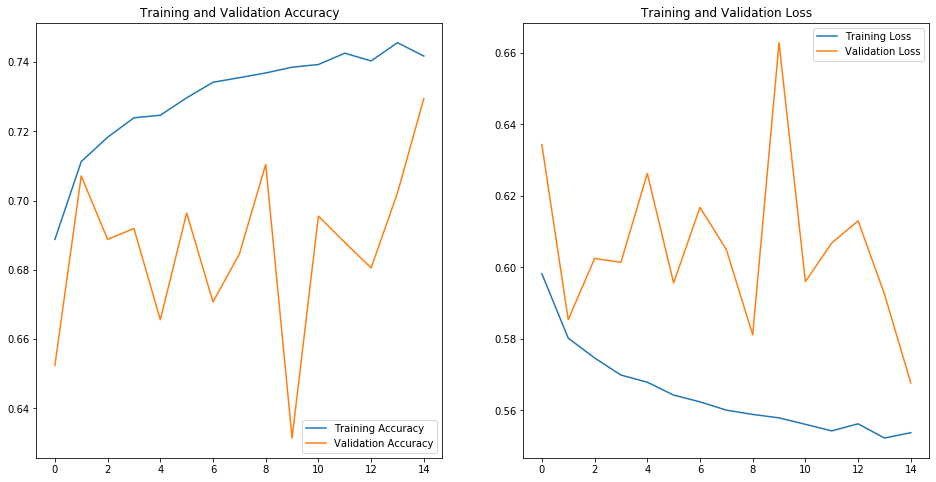

In [26]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 🔴 Evaluate Model on Test Batches

In [27]:
model = tf.keras.models.load_model('model_relu_7570.h5')

In [28]:
loss, accuracy = model.evaluate(test_batches, verbose=0)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.1%}'.format(accuracy))


Loss on the TEST Set: 0.545
Accuracy on the TEST Set: 75.7%


### 🔴 Make Predictions

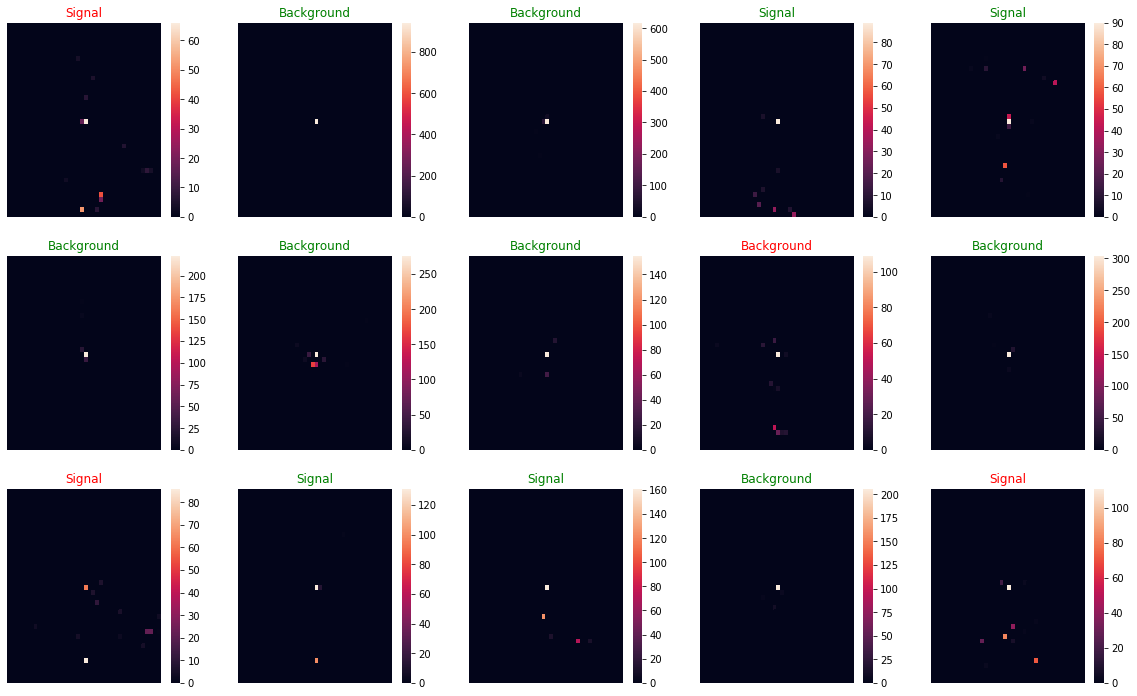

In [29]:
class_names = ['Background', 'Signal']

for event, label in test_batches.take(1):
    ps = model.predict(event)
    images = event.numpy().squeeze()
    labels = label.numpy()


plt.figure(figsize=(20,25))

for n in range(15):
    plt.subplot(6,5,n+1)
    sns.heatmap(images[n])
    #plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

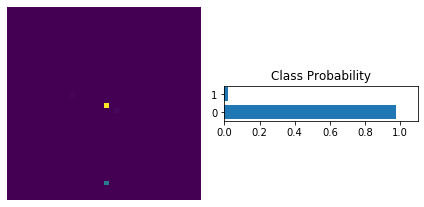

In [30]:
for event, label in train_batches.take(1):
    ps = model.predict(event)
    first_image = event.numpy().squeeze()[0]
  
  
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #sns.heatmap(first_image)
    ax1.imshow(first_image)
    ax1.axis('off')
    ax2.barh(np.arange(2), ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(np.arange(2))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### 🔴 Build Confusion Matrix (using unseen test data)

Guide:
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

In [85]:
preds_all = []
labels_all = []
# preds_batch = []
# labels_batch = []


# For all batches
for n in range(5):
    
    # For all events in a batch
    for event, label in test_batches.take(n):
        # 64 preds and labels added to list
        preds_batch = [np.argmax(model.predict(event)[i]) for i in range(batch_size)]
        labels_batch = label.numpy()

        
#         preds_batch = []
#         for i in range(batch_size):
            
#             preds_batch.append(np.argmax(model.predict(event)[i]))
#             labels_batch = label.numpy()

    #3 lists added to list of lists
    preds_all.append(preds_batch)
    labels_all.append(labels_batch)
    
    
# Convert list of lists to ndarray and flatten to get 1D ndarray of all preds and 1D ndarray of all labels
preds = np.array(preds_all).flatten()
labels = np.array(labels_all).flatten()


Signal = 1 <br />
Background = 0

In [107]:
cmx[0] = cmx[0] / cmx[0].sum()

In [121]:
cmx1

array([0.27407407, 0.72592593])

In [130]:
cmx0
cmx1
np.stack((cmx0, cmx1), axis=0)

array([[0.78918919, 0.21081081],
       [0.27407407, 0.72592593]])

[[0.78918919 0.27407407]
 [0.21081081 0.72592593]] 



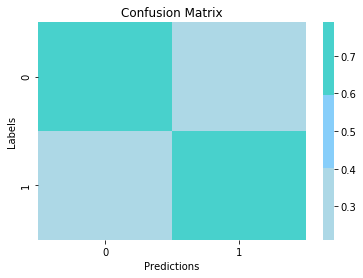



P(signal|signal) = 77.50%
P(signal|background) = 25.78%


False Positives = 25.78%
False Negatives = 22.50%


In [134]:
cmx = tf.math.confusion_matrix(labels, preds).numpy() # Create Confusion Matrix
cmx0 = cmx[0] / cmx[0].sum()
cmx1 = cmx[1] / cmx[1].sum()
cmx = np.stack((cmx0, cmx1), axis=1)


# Normalise it
print(cmx, '\n')


# Plot confusion matrix
sns.heatmap(cmx, cmap=['lightblue', 'lightskyblue', 'mediumturquoise'])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.show()


# Print P(signal|signal) and P(signal|background)
pss = cmx[1,1] / (cmx[1,1]+cmx[1,0])
pbs = 1 - pss
psb = cmx[0,1] / (cmx[0,1]+cmx[0,0])
pbb = 1 - psb
print('\n')
print('P(signal|signal) = {:.2f}%'.format(100*pss))
print('P(signal|background) = {:.2f}%'.format(100*psb))
print('\n')
print('False Positives = {:.2f}%'.format(100*psb))
print('False Negatives = {:.2f}%'.format(100*pbs))